## Import Packages

In [1]:
import torch
import torch.utils.data
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter
from torch.nn.functional import pad
from torch.nn.modules import Module
from torch.nn.modules.utils import _single, _pair, _triple
from torchvision import transforms
from torch.autograd import Variable
from torch.autograd import Function
import torch.optim as optim
import numpy as np
import math
import time
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
import os.path as osp
import os
import PIL
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import copy

In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(25)

## Read People txt file
- Here are 2 examples of the lines in the 'peopleDevTrain.txt' file:
        Aaron_Eckhart	1
        Yoko_Ono	6
        
  The part shows the person name, the figure is the number of images of that person.
  The image path of each person will be:
       name+ '_'+('0000'+str(j))[-4:]+'_0_align_.jpg'

- In this part, the outputs are :
        num_list:      a list of number of images of each person
        name_list:     a list of names of people
        img_path_list:   a list of image path of the images of each person
        
- The output will be the input of the InplaceDataSet function

In [3]:
def create_FaceNet_txt(txt_path,img_folder):
    name_list=open(txt_path, 'r').readlines()
    name_list=[i.split() for i in name_list][1:]
    img_name_list=os.listdir(img_folder)
    img_path_list=[]
    for i in name_list:
        name=i[0]
        num=int(i[1]) 
        img_path_list.append([os.path.join(img_folder,name+'_'+('0000'+str(j))[-4:]+'_0_align_.jpg') for j in range(1,num+1)])
    num_list=[int(i[1]) for i in name_list]
    name_list = [i[0] for i in name_list]
    return num_list,name_list,img_path_list
                
            

## Inplace Dataset
- In the \__init\__ part, it first put the people names with more than 1 images in to the anchor list


- In the \__getitem\__ part, it randomly chooses one image from the images of that person as anchor image. Then, it randomly select another images from the images of that person as positive images. After that, it randomly choose an images of another person as negative image


- The outputs are: 
        anchor image, positive image, negative image

In [4]:
class InplaceDataset(Dataset):
    def __init__(self, num_list,name_list,img_path,transform=False):
        self.name_list=name_list
        self.img_path=img_path
        keep=np.array(num_list)>1
        self.anchor=list(np.array(name_list)[keep])
        self.anchor_path=list(np.array(img_path)[keep])
        self.transform=transform
        
    def __getitem__(self, index):
        img_name,img_path_list=self.anchor[index],self.anchor_path[index]
        anchor_id=np.random.choice(len(img_path_list))
        while True:
            pos_id=np.random.choice(len(img_path_list))
            if pos_id != anchor_id:
                break
        
        while True:
            neg_index=np.random.choice(len(self.name_list))
            if self.name_list[neg_index] != img_name:
                break
        neg_path_list=self.img_path[neg_index]
        neg_id=np.random.choice(len(neg_path_list))
        
        anc=Image.open(img_path_list[anchor_id]).resize((224,224))
        pos=Image.open(img_path_list[pos_id]).resize((224,224))
        neg=Image.open(neg_path_list[neg_id]).resize((224,224)) 
        if self.transform:
            anc=transforms.RandomHorizontalFlip(0.5)(anc)
            anc=transforms.ColorJitter(brightness=0.3, contrast=0.3, hue=0.1)(anc)
            pos=transforms.RandomHorizontalFlip(0.5)(pos)
            pos=transforms.ColorJitter(brightness=0.3, contrast=0.3, hue=0.1)(pos)
            neg=transforms.RandomHorizontalFlip(0.5)(neg)
            neg=transforms.ColorJitter(brightness=0.3, contrast=0.3, hue=0.1)(neg)
        anc,pos,neg=transforms.ToTensor()(anc),transforms.ToTensor()(pos),transforms.ToTensor()(neg)
        anc = transforms.functional.normalize(anc, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        pos = transforms.functional.normalize(pos, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        neg = transforms.functional.normalize(neg, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        return anc,pos,neg

    def __len__(self):
        return len(self.anchor)

## The FaceNet Model with ResNet 18

In [7]:
from torchvision.models import resnet18

class FaceModel(nn.Module):
    def __init__(self,embedding_size=128,pretrained=False):
        super(FaceModel, self).__init__()

        self.model = resnet18(pretrained)

        self.embedding_size = embedding_size

        self.model.fc = nn.Linear(25088, self.embedding_size)      


    def l2_norm(self,input):
        input_size = input.size()
        buffer = torch.pow(input, 2)

        normp = torch.sum(buffer, 1).add_(1e-10)
        norm = torch.sqrt(normp)

        _output = torch.div(input, norm.view(-1, 1).expand_as(input))

        output = _output.view(input_size)

        return output

    def forward(self, x):

        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = x.view(x.size(0), -1)
        x = self.model.fc(x)
        self.features = self.l2_norm(x)
        # Multiply by alpha = 10 as suggested in https://arxiv.org/pdf/1703.09507.pdf
        alpha=10
        self.features = self.features*alpha
        #x = self.model.classifier(self.features)
        return self.features

## The pairwise Distance and The Triplet Margin Loss
- PairwiseDistance:
$$\begin{Vmatrix} x_1 - x_2 \end{Vmatrix}^2_2$$
- The Triple Margin Loss:
$$L = \sum_{i=1}^N \left[ \begin{Vmatrix} f(x^a_i)-f(a^p_i)\end{Vmatrix}^2_2 - \begin{Vmatrix} f(x^a_i)-f(a^p_i)\end{Vmatrix}^2_2 + \alpha \right]_+$$

In [8]:
class PairwiseDistance(nn.Module):
    def __init__(self, p):
        super(PairwiseDistance, self).__init__()
        self.norm = p

    def forward(self, x1, x2):
        assert x1.size() == x2.size()
        eps = 1e-4 / x1.size(1)
        diff = torch.abs(x1 - x2)
        out = torch.pow(diff, self.norm).sum(dim=1)
        return torch.pow(out + eps, 1. / self.norm)

class TripletMarginLoss(nn.Module):
    """Triplet loss function.
    """
    def __init__(self, margin):
        super(TripletMarginLoss, self).__init__()
        self.margin = margin
        self.pdist = PairwiseDistance(2)  # norm 2

    def forward(self, anchor, positive, negative):
        d_p = self.pdist.forward(anchor, positive)
        d_n = self.pdist.forward(anchor, negative)

        dist_hinge = torch.clamp(self.margin + d_p - d_n, min=0.0)
        loss = torch.mean(dist_hinge)
        return loss

## Accuracy and ROC curve
Here shows the calculation of accuracy and ROC:
<table><tbody>
  <tr>
    <td> </td>
    <td> </td>
    <th colspan="2">  Prediction Value</th>
  </tr>
  <tr>
    <td> </td>
    <td> </td>
    <td> 1</td>
    <td > 0</td>    
  </tr>
  <tr>
  <th rowspan="2">Actual Value</th>
    <td> 1</td>
    <td>True Positive</td>
    <td>False Negative</td>
    
  </tr>
   <tr>
    <td> 0</td>
    <td>False Positive</td>
    <td>True Negative</td>
    
  </tr>
</table>

- Accuracy:
$$ Accuracy=\frac{TP+TN}{TP+TN+FP+FN}$$
- True Positive Rate （TPR):
$$ TPR=\frac{TP}{TP+FN}$$
- False Positive Rate （FPR):
$$ FPR=\frac{FP}{TN+FP}$$

In [9]:
def evaluate(distances, labels, nrof_folds=10):
    # Calculate evaluation metrics
    thresholds = np.arange(0, 30, 0.01)
    tpr, fpr, accuracy = calculate_roc(thresholds, distances,
        labels, nrof_folds=nrof_folds)
    return tpr, fpr, accuracy

def calculate_roc(thresholds, distances, labels, nrof_folds=10):

    nrof_pairs = min(len(labels), len(distances))
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    tprs = np.zeros((nrof_folds,nrof_thresholds))
    fprs = np.zeros((nrof_folds,nrof_thresholds))
    accuracy = np.zeros((nrof_folds))

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):

        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx] = calculate_accuracy(threshold, distances[train_set], labels[train_set])
        best_threshold_index = np.argmax(acc_train)
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx,threshold_idx], fprs[fold_idx,threshold_idx], _ = calculate_accuracy(threshold, distances[test_set], labels[test_set])
        _, _, accuracy[fold_idx] = calculate_accuracy(thresholds[best_threshold_index], distances[test_set], labels[test_set])

        tpr = np.mean(tprs,0)
        fpr = np.mean(fprs,0)
    return tpr, fpr, accuracy


def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    acc = float(tp+tn)/dist.size
    return tpr, fpr, acc

## Train Model

In [10]:
def train_and_eval(data_loader, model, optimizer, epoch,mode):
    t0 = time.perf_counter()
    # switch to train mode
    if mode=='Train':
        model.train()
    else:
        model.eval()
    labels, distances = [], []
    show_loss=0
    total_hard_loss=0
    hard_num=0
    for data_a, data_p, data_n in data_loader:

        data_a, data_p, data_n = data_a.cuda(), data_p.cuda(), data_n.cuda()

        # compute output
        out_a, out_p, out_n = model(data_a), model(data_p), model(data_n)
        if mode=='Train':
        # Choose the hard negatives
            d_p = l2_dist.forward(out_a, out_p)
            d_n = l2_dist.forward(out_a, out_n)
            hard = ((d_n - d_p) < margin)
            hard_triplets = torch.where(hard ==1)[0]
            if len(hard_triplets) == 0:
                continue
            out_selected_a = out_a[hard_triplets]
            out_selected_p = out_p[hard_triplets]
            out_selected_n = out_n[hard_triplets]
            
        # compute gradient and update weights        
            optimizer.zero_grad()
            hard_loss = TripletMarginLoss(margin).forward(out_selected_a, out_selected_p, out_selected_n)
            hard_loss.backward()
            optimizer.step()
            total_hard_loss+=hard_loss*len(hard_triplets)
            hard_num+=len(hard_triplets)
            
        loss = TripletMarginLoss(margin).forward(out_a, out_p, out_n)
        show_loss+=loss.item()* out_a.size(0)
        
        
        dists = l2_dist.forward(out_a,out_n)   #torch.sqrt(torch.sum((out_a - out_n) ** 2, 1))  # euclidean distance
        distances.append(dists.data.cpu().numpy())
        labels.append(np.zeros(dists.size(0)))

      
        dists = l2_dist.forward(out_a,out_p) #torch.sqrt(torch.sum((out_a - out_p) ** 2, 1))  # euclidean distance
        distances.append(dists.data.cpu().numpy())
        labels.append(np.ones(dists.size(0)))     
        
    labels = np.array([sublabel for label in labels for sublabel in label])
    distances = np.array([subdist for dist in distances for subdist in dist])
    tpr, fpr, accuracy= evaluate(distances,labels)
    
    if mode=='Train':
        show_loss=show_loss/train_num
        hard_example_num.append(hard_num)
        loss_train.append(show_loss)
        acc_train.append(np.mean(accuracy))
        train_roc[0]=fpr
        train_roc[1]=tpr
        total_hard_loss=total_hard_loss/hard_num
        scheduler.step(total_hard_loss)
    else:
        show_loss=show_loss/eval_num
        loss_eval.append(show_loss)
        acc_eval.append(np.mean(accuracy))
        eval_roc[0]=fpr
        eval_roc[1]=tpr
        if show_loss<best_eval_loss[0]:
            best_eval_loss[0]=show_loss
            best_model_weight[0]=copy.deepcopy(model.state_dict())
            early_stop[0]=0
        else:
            early_stop[0]+=1
    
    t1 = time.perf_counter()
    
    
    print('Epoch: {} {}: | Loss: {:.6f} | Accuracy: {:.6f}| Time: {:.4f} min'.format(epoch,mode,show_loss,np.mean(accuracy),(t1-t0)/60))
    if mode=='Train':
        return model


In [11]:
lr_decay=1e-4
lr=0.01
wd=1e-4
EPOCH=200
margin=0.5
BATCH_SIZE=64
NUM_WORKS=8
train_txt_path='../input/lfw-crop/peopleDevTrain.txt'
eval_txt_path='../input/lfw-crop/peopleDevTest.txt'
img_folder_path='../input/lfw-crop/LFW_cropped/LFW_cropped'
Tnum_list,Tname_list,Timg_path=create_FaceNet_txt(train_txt_path,img_folder_path)
Enum_list,Ename_list,Eimg_path=create_FaceNet_txt(eval_txt_path,img_folder_path)
Train_IDS=InplaceDataset(Tnum_list,Tname_list,Timg_path,transform=True)
Eval_IDS=InplaceDataset(Enum_list,Ename_list,Eimg_path)
train_num=len(Train_IDS)
eval_num=len(Eval_IDS)
train_loader=DataLoader(Train_IDS,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKS)
eval_loader=DataLoader(Eval_IDS,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKS)


In [12]:
model = FaceModel(pretrained=False).cuda()
#optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=wd)
optimizer = optim.Adagrad(model.parameters(), lr=lr,weight_decay=wd)
# optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, 
        verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=2, min_lr=1e-08, eps=1e-08)
l2_dist = PairwiseDistance(2)
loss_train,loss_eval,acc_train,acc_eval=[],[],[],[]
train_roc,eval_roc=[[],[]],[[],[]]
hard_example_num=[]
best_eval_loss=[100]
early_stop=[0]
best_model_weight=[copy.deepcopy(model.state_dict())]
num_train=len(Train_IDS)
num_eval=len(Eval_IDS)
for epoch in range( EPOCH):
    model=train_and_eval(train_loader, model, optimizer, epoch,'Train')
    train_and_eval(eval_loader, model, None, epoch,'Eval')
    if early_stop[0] >10 and best_eval_loss[0]<0.25 and epoch>50:
        break

torch.save(best_model_weight[0],f'train_{EPOCH}_best.pkl')
torch.save(model.state_dict(), f'train_{EPOCH}.pkl')
print('Best eval loss: ',best_eval_loss[0])


Epoch: 0 Train: | Loss: 0.517744 | Accuracy: 0.528277| Time: 0.4706 min
Epoch: 0 Eval: | Loss: 0.448149 | Accuracy: 0.566556| Time: 0.1360 min
Epoch: 1 Train: | Loss: 0.413693 | Accuracy: 0.592505| Time: 0.4788 min
Epoch: 1 Eval: | Loss: 0.362622 | Accuracy: 0.610869| Time: 0.1343 min
Epoch: 2 Train: | Loss: 0.381313 | Accuracy: 0.596712| Time: 0.4659 min
Epoch: 2 Eval: | Loss: 0.360748 | Accuracy: 0.603798| Time: 0.1370 min
Epoch: 3 Train: | Loss: 0.338895 | Accuracy: 0.630501| Time: 0.4754 min
Epoch: 3 Eval: | Loss: 0.339967 | Accuracy: 0.606909| Time: 0.1359 min
Epoch: 4 Train: | Loss: 0.331436 | Accuracy: 0.629187| Time: 0.4695 min
Epoch: 4 Eval: | Loss: 0.361952 | Accuracy: 0.619949| Time: 0.1427 min
Epoch: 5 Train: | Loss: 0.327314 | Accuracy: 0.654155| Time: 0.4643 min
Epoch: 5 Eval: | Loss: 0.372477 | Accuracy: 0.669343| Time: 0.1407 min
Epoch: 6 Train: | Loss: 0.326865 | Accuracy: 0.633455| Time: 0.4723 min
Epoch: 6 Eval: | Loss: 0.315852 | Accuracy: 0.666333| Time: 0.1346 min

## Show The Loss curve

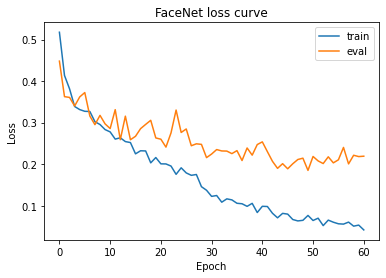

In [13]:
x=np.arange(len(loss_train))
plt.plot(x,loss_train,label='train')
plt.plot(x,loss_eval,label='eval')
plt.title('FaceNet loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Show the Accuracy curve

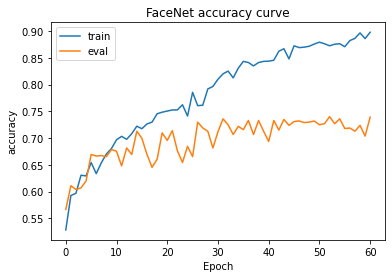

In [14]:
plt.plot(x,acc_train,label='train')
plt.plot(x,acc_eval,label='eval')
plt.title('FaceNet accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## Show the ROC curve

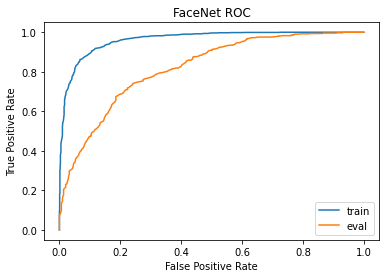

In [15]:
plt.plot(train_roc[0],train_roc[1],label='train')
plt.plot(eval_roc[0],eval_roc[1],label='eval')
plt.title('FaceNet ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Show the change of the number of hard negatives

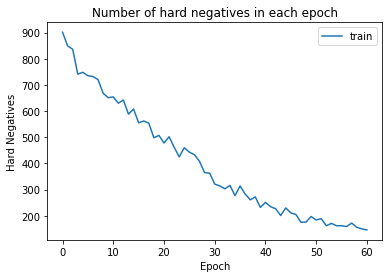

In [16]:
plt.plot(np.arange(len(hard_example_num)),hard_example_num,label='train')
plt.title('Number of hard negatives in each epoch')
plt.xlabel('Epoch')
plt.ylabel('Hard Negatives')
plt.legend()
plt.show()